In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import re
from scipy.stats import randint
from scipy.stats import spearmanr
import plotly.express as px
from transformers import BertModel, BertTokenizer
import torch
import re
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test_labels.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


# Data Preparation

In [3]:
def load_fixed_train_df(original_train_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm 
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df

In [4]:
# Load the Fixed Train dataframe
train_df = load_fixed_train_df()
test_df = pd.read_csv("../input/novozymes-enzyme-stability-prediction/test.csv")
sub_df = pd.read_csv("../input/novozymes-enzyme-stability-prediction/sample_submission.csv")

In [5]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.4
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,45.7
7,7,AAENRPPIPGSLGMLYDSTLCVGCQACVTKCQDINFPERNPQGEQT...,7.0,doi.org/10.1038/s41592-020-0801-4,55.9
8,8,AAEYAVVLKTLSNPFWVDMKKGIEDEAKTLGVSVDIFASPSEGDFQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
9,9,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,doi.org/10.1038/s41592-020-0801-4,49.7


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28981 entries, 0 to 28980
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


In [12]:
unique_values = train_df['protein_sequence'].unique()
len(unique_values)

27375

In [13]:
unique_tem = train_df['tm'].unique()
len(unique_tem)

725

In [14]:
unique_ph = train_df['pH'].unique()
len(unique_ph)

105

In [7]:
# Split the data into train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

# Exploratory Data Analysis

In [8]:
train_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                  232
data_source         788
tm                    0
dtype: int64

In [9]:
val_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                   54
data_source         192
tm                    0
dtype: int64

In [10]:
train_df.describe()

,seq_id,pH,tm
count,23184.000000,22952.000000,23184.000000
mean,15723.463509,6.874492,51.329559
std,9277.265390,0.791885,12.054404
min,0.000000,1.990000,25.100000
25%,7441.500000,7.000000,43.600000
50%,15561.500000,7.000000,48.800000
75%,23885.250000,7.000000,54.600000
max,31389.000000,11.000000,130.000000


In [11]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
5653,5884,MAQSHSSSINYFGSANKVVYEGKDSTNPLAFKYYNPQEVIGGKTLK...,7.0,doi.org/10.1038/s41592-020-0801-4,41.8
15912,17717,MMNLDFDFSASGIRTIQIEQEAIANLKSHIGDDFIGACKYMLACQG...,7.0,doi.org/10.1038/s41592-020-0801-4,43.6
20717,22866,MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...,7.0,doi.org/10.1038/s41592-020-0801-4,38.9
10385,10949,MGCAVSTARDKEAIERSKNIDRALRAEGERAASEVKLLLLGAGESG...,7.0,doi.org/10.1038/s41592-020-0801-4,35.4
17694,19680,MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGHGIYVYDDQ...,8.0,10.1021/acscatal.9b05223,62.0
21696,23857,MSGGLGFAIDRGGTFTDVIVFKPNSEVEVLKVLSVDPANYTDAPTE...,7.0,doi.org/10.1038/s41592-020-0801-4,47.0
3732,3854,MADQRQRSLSTSGESLYHVLGLDKNATSDDIKKSYRKLALKYHPDK...,7.0,doi.org/10.1038/s41592-020-0801-4,48.7
10951,11591,MGLHSEPLDQEDQDTIILDARAGDLDSLKDIFTTLVSPELLSTCKE...,7.0,doi.org/10.1038/s41592-020-0801-4,55.3
8647,8993,MEGPLTIPVLDKGFVRLVDQMGDDRAIVQAARVSYGEGTKTVREDA...,7.0,doi.org/10.1038/s41592-020-0801-4,91.8
1719,1768,GKPDFFETKAVNGSLVKSRPVRSVAEAPAPIDCELSTWSSWTACDP...,7.0,doi.org/10.1038/s41592-020-0801-4,59.6


In [12]:
val_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
16502,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0
843,857,DIIGEPKIRCAPTGITIMLETDSPFKGALFLRGSADKKSCKANFSA...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2
5731,5965,MARILGVGRSSASSLNNKEDNESDVALLSPKDPNRVHTKEQLAHPA...,7.0,doi.org/10.1038/s41592-020-0801-4,57.6
8663,9009,MEGSGKLAMVEDAVEYHLFLIPDKARGTEEHREILQKYIERIMTQF...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
27605,30009,QNSDIESLKASNGDSFPWNNMRLPEYMTPIHYDLMIHANLSTLTFW...,7.0,doi.org/10.1038/s41592-020-0801-4,53.1
23213,25436,MSRRRHSYENDGGQPHKRRKTSDANETEDHLESLICKVGEKSACSL...,7.0,doi.org/10.1038/s41592-020-0801-4,49.0
11541,12211,MHKHQHCCKCPECYEVTRLAALRRLEPPGYGDWQVPDPYGPSGGNG...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
10709,11346,MGHELLRQPKWRVIDQSHFGPLFDAKQSFAIDDALCTAVGAGQSDA...,7.0,doi.org/10.1038/s41592-020-0801-4,70.4
22082,24265,MSKGRVNQKRYKYPLPIHPVDDLPELILHNPLSWLYWAYRYYKSTN...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
25458,27792,MTSSPFLDPWPSKAVFVRERLGLGERPNDSYCYNSAKNSTVLQGVT...,7.0,doi.org/10.1038/s41592-020-0801-4,50.6


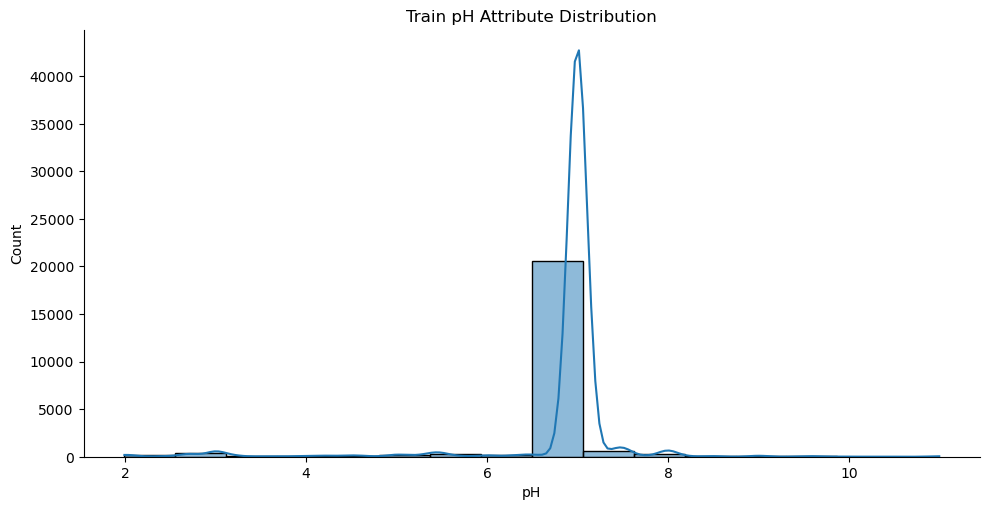

In [13]:
# Train PH Attribute Distribution
sns.displot(train_df['pH'], aspect=2, height=5, kde=True).set(title="Train pH Attribute Distribution")

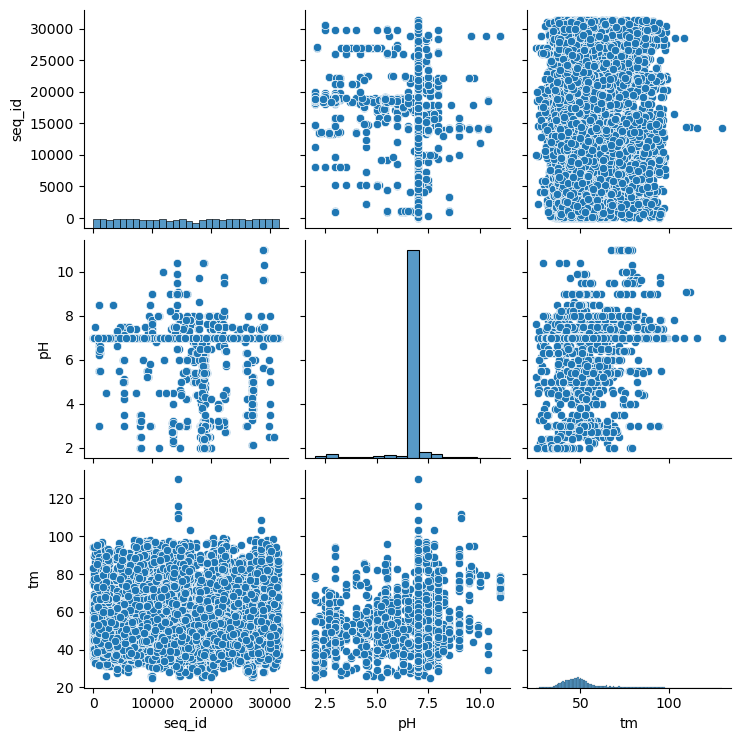

In [14]:
sns.pairplot(train_df)

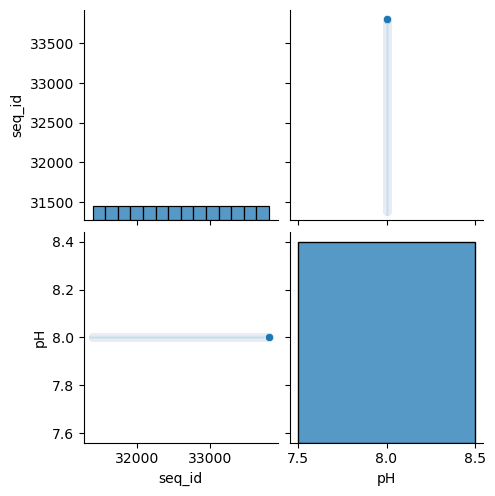

In [15]:
sns.pairplot(test_df)

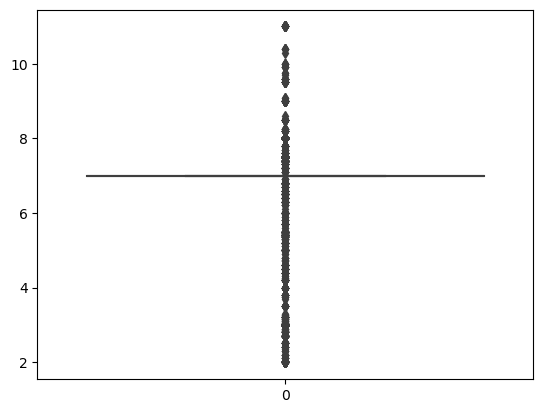

In [16]:
sns.boxplot(train_df["pH"])
plt.show()

# Impute the Missing Values in PH Attribute with Mean

In [17]:
imputer = SimpleImputer(strategy="mean")
train_df["pH"] = imputer.fit_transform(train_df[["pH"]]).ravel()
val_df["pH"] = imputer.transform(val_df[["pH"]]).ravel()

In [18]:
train_df['pH'].isnull().sum() 

0

In [19]:
import numpy as np
# np.random.seed(0)
# train_df
sort_train = sorted(train_df['pH'])

sort_train = sorted(round(train_df['pH']))
# print(sort_train, end = " ")

# Extract Features from Pretrained ProtBert Model
# Load the ProtBert Model for Feature Extraction

In [20]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")
model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False

In [21]:
def extract_features(df):    
    embeddings_list = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        sequence_Example = ' '.join(row["protein_sequence"])
        sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
        encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(**encoded_input)
            output = output[1].detach().cpu().numpy()[0]
            embeddings_list.append(output)
            torch.cuda.empty_cache()

    return embeddings_list

In [ ]:
train_features = extract_features(train_df)
valid_features = extract_features(val_df)
test_features = extract_features(test_df)

# Convert Extracted Features into Dense Columns

In [25]:
def convert_to_dense_columns(features_array):    
    df = pd.DataFrame(features_array)
    df.columns = ['Feature_' + str(x) for x in df.columns]
    return df

In [26]:
train_feats_df = convert_to_dense_columns(train_features)
val_feats_df = convert_to_dense_columns(valid_features)
test_feats_df = convert_to_dense_columns(test_features)

In [27]:
train_feats_df.head(10)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,-0.244507,0.258234,-0.232656,-0.246817,-0.264462,-0.258669,-0.256564,-0.253849,0.238173,-0.249974,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236184,0.242557,0.246115,0.229978,-0.251330
1,-0.243061,0.256727,-0.231266,-0.245361,-0.262928,-0.257160,-0.255064,-0.252361,0.236757,-0.248504,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,-0.264707,0.279267,-0.252097,-0.267160,-0.285857,-0.279726,-0.277497,-0.274621,0.257974,-0.270510,...,0.271344,-0.262115,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266416,0.249249,-0.271950
3,-0.251635,0.265610,-0.239549,-0.253988,-0.271943,-0.266051,-0.263910,-0.261149,0.245180,-0.257203,...,0.258002,-0.249149,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,-0.249014,0.262933,-0.236989,-0.251357,-0.269244,-0.263373,-0.261239,-0.258487,0.242589,-0.254559,...,0.255353,-0.246538,0.260529,-0.258162,-0.256221,-0.240571,0.247036,0.250645,0.234273,-0.255934
5,-0.284511,0.299959,-0.271106,-0.287116,-0.306940,-0.300444,-0.298082,-0.295031,0.277357,-0.290672,...,0.291556,-0.281757,0.297296,-0.294669,-0.292514,-0.275107,0.282309,0.286326,0.268076,-0.292199
6,-0.269089,0.283872,-0.256284,-0.271580,-0.290562,-0.284338,-0.282075,-0.279155,0.262252,-0.274982,...,0.275828,-0.266457,0.281322,-0.278808,-0.276746,-0.260103,0.266985,0.270825,0.253390,-0.276443
7,-0.274234,0.289239,-0.261230,-0.276764,-0.296026,-0.289712,-0.287416,-0.284452,0.267292,-0.280217,...,0.281075,-0.271562,0.286651,-0.284100,-0.282007,-0.265109,0.272098,0.275997,0.258290,-0.281700
8,-0.270884,0.285707,-0.258035,-0.273382,-0.292413,-0.286174,-0.283905,-0.280979,0.264025,-0.276793,...,0.277642,-0.268243,0.283151,-0.280629,-0.278561,-0.261869,0.268773,0.272624,0.255133,-0.278259
9,-0.288983,0.304606,-0.275418,-0.291618,-0.311663,-0.305097,-0.302708,-0.299624,0.281745,-0.295215,...,0.296109,-0.286197,0.301914,-0.299257,-0.297078,-0.279468,0.286755,0.290820,0.272351,-0.296759


# Create Protein Sequence Length as Feature (Hand Engineering)

In [28]:
train_df["protein_length"] = train_df["protein_sequence"].apply(lambda x: len(x))
val_df["protein_length"] = val_df["protein_sequence"].apply(lambda x: len(x))
test_df["protein_length"] = test_df["protein_sequence"].apply(lambda x: len(x))

In [29]:
def return_amino_acid_df(df):    
    # Feature Engineering on Train Data
    search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    for amino_acid in search_amino:
         df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)
    return df

# Retriving the Amino Acid DataFrame for Train, Val and Test Set

In [30]:
train_df = return_amino_acid_df(train_df)
val_df = return_amino_acid_df(val_df)
test_df = return_amino_acid_df(test_df)

# Dropping the unwanted Columns

In [31]:
# Dropping Unnecessary Columns
train_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
val_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
test_df.drop(columns=["seq_id", "protein_sequence", "data_source"], inplace=True)

In [32]:
train_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
5653,7.0,41.8,444,44,1,27,32,27,35,19,...,15,24,12,14,18,18,28,17,5,20
15912,7.0,43.6,323,33,4,19,16,9,33,10,...,18,6,13,8,10,25,26,21,0,1
20717,7.0,38.9,413,34,8,21,18,19,42,9,...,7,12,15,19,19,52,25,37,1,10
10385,7.0,35.4,354,25,8,19,29,19,18,6,...,8,16,6,14,22,22,22,20,3,10
17694,8.0,62.0,455,45,5,15,31,20,46,17,...,13,13,24,25,19,25,16,30,4,14


In [33]:
val_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
16502,3.0,52.0,164,15,3,10,8,5,10,1,...,5,12,3,5,13,5,11,9,3,6
843,7.0,52.2,362,20,13,19,22,16,24,9,...,6,16,19,10,17,39,19,27,2,12
5731,7.0,57.6,732,41,5,39,46,21,48,24,...,9,31,84,34,64,75,36,33,16,17
8663,7.0,48.1,640,55,7,49,52,28,33,17,...,16,18,46,33,30,54,19,35,6,19
27605,7.0,53.1,909,54,9,45,66,45,38,23,...,34,40,35,39,33,80,57,50,21,33


In [34]:
test_df.head(10)

,pH,protein_length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,221,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,221,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,220,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,221,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
5,8,221,22,4,15,7,10,20,0,6,...,0,19,17,13,3,18,8,13,6,6
6,8,221,22,4,15,7,10,19,1,6,...,0,19,17,13,3,18,8,13,6,6
7,8,221,22,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
8,8,221,23,4,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6
9,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6


# Reset the DataFrame indexes

In [35]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [36]:
test_df.head(10)

,pH,protein_length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,221,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,221,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,220,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,221,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
5,8,221,22,4,15,7,10,20,0,6,...,0,19,17,13,3,18,8,13,6,6
6,8,221,22,4,15,7,10,19,1,6,...,0,19,17,13,3,18,8,13,6,6
7,8,221,22,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
8,8,221,23,4,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6
9,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6


# Combine ProBert Extracted Features with Hand Engineered Features

In [37]:
train_df_concat = pd.concat([train_df, train_feats_df], axis=1)
val_df_concat = pd.concat([val_df, val_feats_df], axis=1)
test_df_concat = pd.concat([test_df, test_feats_df], axis=1)

In [38]:
train_df_concat.head(10)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,7.0,41.8,444,44,1,27,32,27,35,19,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236184,0.242557,0.246115,0.229978,-0.251330
1,7.0,43.6,323,33,4,19,16,9,33,10,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,7.0,38.9,413,34,8,21,18,19,42,9,...,0.271344,-0.262115,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266416,0.249249,-0.271950
3,7.0,35.4,354,25,8,19,29,19,18,6,...,0.258002,-0.249149,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,8.0,62.0,455,45,5,15,31,20,46,17,...,0.255353,-0.246538,0.260529,-0.258162,-0.256221,-0.240571,0.247036,0.250645,0.234273,-0.255934
5,7.0,47.0,1256,90,21,67,92,60,121,28,...,0.291556,-0.281757,0.297296,-0.294669,-0.292514,-0.275107,0.282309,0.286326,0.268076,-0.292199
6,7.0,48.7,140,12,14,9,6,5,7,3,...,0.275828,-0.266457,0.281322,-0.278808,-0.276746,-0.260103,0.266985,0.270825,0.253390,-0.276443
7,7.0,55.3,199,16,2,17,28,6,9,5,...,0.281075,-0.271562,0.286651,-0.284100,-0.282007,-0.265109,0.272098,0.275997,0.258290,-0.281700
8,7.0,91.8,269,32,0,8,30,14,16,7,...,0.277642,-0.268243,0.283151,-0.280629,-0.278561,-0.261869,0.268773,0.272624,0.255133,-0.278259
9,7.0,59.6,557,32,28,28,42,21,41,13,...,0.296109,-0.286197,0.301914,-0.299257,-0.297078,-0.279468,0.286755,0.290820,0.272351,-0.296759


In [39]:
# Seperate Dependent and Independent Variables
X_train = train_df_concat.drop(columns=["tm"])
y_train = train_df_concat["tm"]

X_val = val_df_concat.drop(columns=["tm"])
y_val = val_df_concat["tm"]

X_test = test_df_concat

In [55]:
X_train

,pH,protein_length,A,C,D,E,F,G,H,I,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,7.0,444,44,1,27,32,27,35,19,20,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236184,0.242557,0.246115,0.229978,-0.251330
1,7.0,323,33,4,19,16,9,33,10,21,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,7.0,413,34,8,21,18,19,42,9,14,...,0.271344,-0.262115,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266416,0.249249,-0.271950
3,7.0,354,25,8,19,29,19,18,6,29,...,0.258002,-0.249149,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,8.0,455,45,5,15,31,20,46,17,32,...,0.255353,-0.246538,0.260529,-0.258162,-0.256221,-0.240571,0.247036,0.250645,0.234273,-0.255934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23179,7.0,325,31,3,15,37,13,6,4,14,...,0.280429,-0.270930,0.285997,-0.283449,-0.281359,-0.264488,0.271466,0.275358,0.257681,-0.281053
23180,7.0,332,32,9,17,25,6,25,7,19,...,0.235871,-0.227595,0.240737,-0.238514,-0.236689,-0.222001,0.228063,0.231449,0.216102,-0.236417
23181,7.0,510,31,13,20,46,15,45,9,18,...,0.267940,-0.258794,0.273304,-0.270850,-0.268837,-0.252596,0.259309,0.263056,0.246049,-0.268541
23182,7.0,893,80,25,41,74,32,34,27,19,...,0.292877,-0.283053,0.298631,-0.295997,-0.293837,-0.276384,0.283606,0.287634,0.269332,-0.293521


# Modelling Fit the Model Performance

In [40]:
model = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=150, tree_method="gpu_hist")
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [41]:
# Checking the performance of the model on Train, Val and Test Set
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print("Mean Absolute error on Train data is:{}".format(mean_absolute_error(y_train, y_pred_train)))
print("Mean Absolute error on Val data is:{}".format(mean_absolute_error(y_val, y_pred_val)))

Mean Absolute error on Train data is:3.7463136276925657
Mean Absolute error on Val data is:5.542515871338502


In [42]:
# Correlation Value
print("Training Correlation Value: {}".format(spearmanr(y_pred_train, y_train)))
print("Validation Correlation Value: {}".format(spearmanr(y_pred_val, y_val)))

Training Correlation Value: SpearmanrResult(correlation=0.8263408815333209, pvalue=0.0)
Validation Correlation Value: SpearmanrResult(correlation=0.5829811425672533, pvalue=0.0)


In [46]:
# R2 Score Value
from sklearn.metrics import r2_score
# print("R2 Score Value: {}", r2_score(y_pred_train, y_train))
# print("R2 Score Value: {}".format(r2_score(y_pred_val, y_val)))
print("Testing R2_Score:",r2_score(y_train, model.predict(X_train)))
print("Validation R2_Score:",r2_score(X_train, model.predict(y_train)))

Testing R2_Score: 0.8273469740287015


ValueError: training data did not have the following fields: pH, protein_length, A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y, Feature_0, Feature_1, Feature_2, Feature_3, Feature_4, Feature_5, Feature_6, Feature_7, Feature_8, Feature_9, Feature_10, Feature_11, Feature_12, Feature_13, Feature_14, Feature_15, Feature_16, Feature_17, Feature_18, Feature_19, Feature_20, Feature_21, Feature_22, Feature_23, Feature_24, Feature_25, Feature_26, Feature_27, Feature_28, Feature_29, Feature_30, Feature_31, Feature_32, Feature_33, Feature_34, Feature_35, Feature_36, Feature_37, Feature_38, Feature_39, Feature_40, Feature_41, Feature_42, Feature_43, Feature_44, Feature_45, Feature_46, Feature_47, Feature_48, Feature_49, Feature_50, Feature_51, Feature_52, Feature_53, Feature_54, Feature_55, Feature_56, Feature_57, Feature_58, Feature_59, Feature_60, Feature_61, Feature_62, Feature_63, Feature_64, Feature_65, Feature_66, Feature_67, Feature_68, Feature_69, Feature_70, Feature_71, Feature_72, Feature_73, Feature_74, Feature_75, Feature_76, Feature_77, Feature_78, Feature_79, Feature_80, Feature_81, Feature_82, Feature_83, Feature_84, Feature_85, Feature_86, Feature_87, Feature_88, Feature_89, Feature_90, Feature_91, Feature_92, Feature_93, Feature_94, Feature_95, Feature_96, Feature_97, Feature_98, Feature_99, Feature_100, Feature_101, Feature_102, Feature_103, Feature_104, Feature_105, Feature_106, Feature_107, Feature_108, Feature_109, Feature_110, Feature_111, Feature_112, Feature_113, Feature_114, Feature_115, Feature_116, Feature_117, Feature_118, Feature_119, Feature_120, Feature_121, Feature_122, Feature_123, Feature_124, Feature_125, Feature_126, Feature_127, Feature_128, Feature_129, Feature_130, Feature_131, Feature_132, Feature_133, Feature_134, Feature_135, Feature_136, Feature_137, Feature_138, Feature_139, Feature_140, Feature_141, Feature_142, Feature_143, Feature_144, Feature_145, Feature_146, Feature_147, Feature_148, Feature_149, Feature_150, Feature_151, Feature_152, Feature_153, Feature_154, Feature_155, Feature_156, Feature_157, Feature_158, Feature_159, Feature_160, Feature_161, Feature_162, Feature_163, Feature_164, Feature_165, Feature_166, Feature_167, Feature_168, Feature_169, Feature_170, Feature_171, Feature_172, Feature_173, Feature_174, Feature_175, Feature_176, Feature_177, Feature_178, Feature_179, Feature_180, Feature_181, Feature_182, Feature_183, Feature_184, Feature_185, Feature_186, Feature_187, Feature_188, Feature_189, Feature_190, Feature_191, Feature_192, Feature_193, Feature_194, Feature_195, Feature_196, Feature_197, Feature_198, Feature_199, Feature_200, Feature_201, Feature_202, Feature_203, Feature_204, Feature_205, Feature_206, Feature_207, Feature_208, Feature_209, Feature_210, Feature_211, Feature_212, Feature_213, Feature_214, Feature_215, Feature_216, Feature_217, Feature_218, Feature_219, Feature_220, Feature_221, Feature_222, Feature_223, Feature_224, Feature_225, Feature_226, Feature_227, Feature_228, Feature_229, Feature_230, Feature_231, Feature_232, Feature_233, Feature_234, Feature_235, Feature_236, Feature_237, Feature_238, Feature_239, Feature_240, Feature_241, Feature_242, Feature_243, Feature_244, Feature_245, Feature_246, Feature_247, Feature_248, Feature_249, Feature_250, Feature_251, Feature_252, Feature_253, Feature_254, Feature_255, Feature_256, Feature_257, Feature_258, Feature_259, Feature_260, Feature_261, Feature_262, Feature_263, Feature_264, Feature_265, Feature_266, Feature_267, Feature_268, Feature_269, Feature_270, Feature_271, Feature_272, Feature_273, Feature_274, Feature_275, Feature_276, Feature_277, Feature_278, Feature_279, Feature_280, Feature_281, Feature_282, Feature_283, Feature_284, Feature_285, Feature_286, Feature_287, Feature_288, Feature_289, Feature_290, Feature_291, Feature_292, Feature_293, Feature_294, Feature_295, Feature_296, Feature_297, Feature_298, Feature_299, Feature_300, Feature_301, Feature_302, Feature_303, Feature_304, Feature_305, Feature_306, Feature_307, Feature_308, Feature_309, Feature_310, Feature_311, Feature_312, Feature_313, Feature_314, Feature_315, Feature_316, Feature_317, Feature_318, Feature_319, Feature_320, Feature_321, Feature_322, Feature_323, Feature_324, Feature_325, Feature_326, Feature_327, Feature_328, Feature_329, Feature_330, Feature_331, Feature_332, Feature_333, Feature_334, Feature_335, Feature_336, Feature_337, Feature_338, Feature_339, Feature_340, Feature_341, Feature_342, Feature_343, Feature_344, Feature_345, Feature_346, Feature_347, Feature_348, Feature_349, Feature_350, Feature_351, Feature_352, Feature_353, Feature_354, Feature_355, Feature_356, Feature_357, Feature_358, Feature_359, Feature_360, Feature_361, Feature_362, Feature_363, Feature_364, Feature_365, Feature_366, Feature_367, Feature_368, Feature_369, Feature_370, Feature_371, Feature_372, Feature_373, Feature_374, Feature_375, Feature_376, Feature_377, Feature_378, Feature_379, Feature_380, Feature_381, Feature_382, Feature_383, Feature_384, Feature_385, Feature_386, Feature_387, Feature_388, Feature_389, Feature_390, Feature_391, Feature_392, Feature_393, Feature_394, Feature_395, Feature_396, Feature_397, Feature_398, Feature_399, Feature_400, Feature_401, Feature_402, Feature_403, Feature_404, Feature_405, Feature_406, Feature_407, Feature_408, Feature_409, Feature_410, Feature_411, Feature_412, Feature_413, Feature_414, Feature_415, Feature_416, Feature_417, Feature_418, Feature_419, Feature_420, Feature_421, Feature_422, Feature_423, Feature_424, Feature_425, Feature_426, Feature_427, Feature_428, Feature_429, Feature_430, Feature_431, Feature_432, Feature_433, Feature_434, Feature_435, Feature_436, Feature_437, Feature_438, Feature_439, Feature_440, Feature_441, Feature_442, Feature_443, Feature_444, Feature_445, Feature_446, Feature_447, Feature_448, Feature_449, Feature_450, Feature_451, Feature_452, Feature_453, Feature_454, Feature_455, Feature_456, Feature_457, Feature_458, Feature_459, Feature_460, Feature_461, Feature_462, Feature_463, Feature_464, Feature_465, Feature_466, Feature_467, Feature_468, Feature_469, Feature_470, Feature_471, Feature_472, Feature_473, Feature_474, Feature_475, Feature_476, Feature_477, Feature_478, Feature_479, Feature_480, Feature_481, Feature_482, Feature_483, Feature_484, Feature_485, Feature_486, Feature_487, Feature_488, Feature_489, Feature_490, Feature_491, Feature_492, Feature_493, Feature_494, Feature_495, Feature_496, Feature_497, Feature_498, Feature_499, Feature_500, Feature_501, Feature_502, Feature_503, Feature_504, Feature_505, Feature_506, Feature_507, Feature_508, Feature_509, Feature_510, Feature_511, Feature_512, Feature_513, Feature_514, Feature_515, Feature_516, Feature_517, Feature_518, Feature_519, Feature_520, Feature_521, Feature_522, Feature_523, Feature_524, Feature_525, Feature_526, Feature_527, Feature_528, Feature_529, Feature_530, Feature_531, Feature_532, Feature_533, Feature_534, Feature_535, Feature_536, Feature_537, Feature_538, Feature_539, Feature_540, Feature_541, Feature_542, Feature_543, Feature_544, Feature_545, Feature_546, Feature_547, Feature_548, Feature_549, Feature_550, Feature_551, Feature_552, Feature_553, Feature_554, Feature_555, Feature_556, Feature_557, Feature_558, Feature_559, Feature_560, Feature_561, Feature_562, Feature_563, Feature_564, Feature_565, Feature_566, Feature_567, Feature_568, Feature_569, Feature_570, Feature_571, Feature_572, Feature_573, Feature_574, Feature_575, Feature_576, Feature_577, Feature_578, Feature_579, Feature_580, Feature_581, Feature_582, Feature_583, Feature_584, Feature_585, Feature_586, Feature_587, Feature_588, Feature_589, Feature_590, Feature_591, Feature_592, Feature_593, Feature_594, Feature_595, Feature_596, Feature_597, Feature_598, Feature_599, Feature_600, Feature_601, Feature_602, Feature_603, Feature_604, Feature_605, Feature_606, Feature_607, Feature_608, Feature_609, Feature_610, Feature_611, Feature_612, Feature_613, Feature_614, Feature_615, Feature_616, Feature_617, Feature_618, Feature_619, Feature_620, Feature_621, Feature_622, Feature_623, Feature_624, Feature_625, Feature_626, Feature_627, Feature_628, Feature_629, Feature_630, Feature_631, Feature_632, Feature_633, Feature_634, Feature_635, Feature_636, Feature_637, Feature_638, Feature_639, Feature_640, Feature_641, Feature_642, Feature_643, Feature_644, Feature_645, Feature_646, Feature_647, Feature_648, Feature_649, Feature_650, Feature_651, Feature_652, Feature_653, Feature_654, Feature_655, Feature_656, Feature_657, Feature_658, Feature_659, Feature_660, Feature_661, Feature_662, Feature_663, Feature_664, Feature_665, Feature_666, Feature_667, Feature_668, Feature_669, Feature_670, Feature_671, Feature_672, Feature_673, Feature_674, Feature_675, Feature_676, Feature_677, Feature_678, Feature_679, Feature_680, Feature_681, Feature_682, Feature_683, Feature_684, Feature_685, Feature_686, Feature_687, Feature_688, Feature_689, Feature_690, Feature_691, Feature_692, Feature_693, Feature_694, Feature_695, Feature_696, Feature_697, Feature_698, Feature_699, Feature_700, Feature_701, Feature_702, Feature_703, Feature_704, Feature_705, Feature_706, Feature_707, Feature_708, Feature_709, Feature_710, Feature_711, Feature_712, Feature_713, Feature_714, Feature_715, Feature_716, Feature_717, Feature_718, Feature_719, Feature_720, Feature_721, Feature_722, Feature_723, Feature_724, Feature_725, Feature_726, Feature_727, Feature_728, Feature_729, Feature_730, Feature_731, Feature_732, Feature_733, Feature_734, Feature_735, Feature_736, Feature_737, Feature_738, Feature_739, Feature_740, Feature_741, Feature_742, Feature_743, Feature_744, Feature_745, Feature_746, Feature_747, Feature_748, Feature_749, Feature_750, Feature_751, Feature_752, Feature_753, Feature_754, Feature_755, Feature_756, Feature_757, Feature_758, Feature_759, Feature_760, Feature_761, Feature_762, Feature_763, Feature_764, Feature_765, Feature_766, Feature_767, Feature_768, Feature_769, Feature_770, Feature_771, Feature_772, Feature_773, Feature_774, Feature_775, Feature_776, Feature_777, Feature_778, Feature_779, Feature_780, Feature_781, Feature_782, Feature_783, Feature_784, Feature_785, Feature_786, Feature_787, Feature_788, Feature_789, Feature_790, Feature_791, Feature_792, Feature_793, Feature_794, Feature_795, Feature_796, Feature_797, Feature_798, Feature_799, Feature_800, Feature_801, Feature_802, Feature_803, Feature_804, Feature_805, Feature_806, Feature_807, Feature_808, Feature_809, Feature_810, Feature_811, Feature_812, Feature_813, Feature_814, Feature_815, Feature_816, Feature_817, Feature_818, Feature_819, Feature_820, Feature_821, Feature_822, Feature_823, Feature_824, Feature_825, Feature_826, Feature_827, Feature_828, Feature_829, Feature_830, Feature_831, Feature_832, Feature_833, Feature_834, Feature_835, Feature_836, Feature_837, Feature_838, Feature_839, Feature_840, Feature_841, Feature_842, Feature_843, Feature_844, Feature_845, Feature_846, Feature_847, Feature_848, Feature_849, Feature_850, Feature_851, Feature_852, Feature_853, Feature_854, Feature_855, Feature_856, Feature_857, Feature_858, Feature_859, Feature_860, Feature_861, Feature_862, Feature_863, Feature_864, Feature_865, Feature_866, Feature_867, Feature_868, Feature_869, Feature_870, Feature_871, Feature_872, Feature_873, Feature_874, Feature_875, Feature_876, Feature_877, Feature_878, Feature_879, Feature_880, Feature_881, Feature_882, Feature_883, Feature_884, Feature_885, Feature_886, Feature_887, Feature_888, Feature_889, Feature_890, Feature_891, Feature_892, Feature_893, Feature_894, Feature_895, Feature_896, Feature_897, Feature_898, Feature_899, Feature_900, Feature_901, Feature_902, Feature_903, Feature_904, Feature_905, Feature_906, Feature_907, Feature_908, Feature_909, Feature_910, Feature_911, Feature_912, Feature_913, Feature_914, Feature_915, Feature_916, Feature_917, Feature_918, Feature_919, Feature_920, Feature_921, Feature_922, Feature_923, Feature_924, Feature_925, Feature_926, Feature_927, Feature_928, Feature_929, Feature_930, Feature_931, Feature_932, Feature_933, Feature_934, Feature_935, Feature_936, Feature_937, Feature_938, Feature_939, Feature_940, Feature_941, Feature_942, Feature_943, Feature_944, Feature_945, Feature_946, Feature_947, Feature_948, Feature_949, Feature_950, Feature_951, Feature_952, Feature_953, Feature_954, Feature_955, Feature_956, Feature_957, Feature_958, Feature_959, Feature_960, Feature_961, Feature_962, Feature_963, Feature_964, Feature_965, Feature_966, Feature_967, Feature_968, Feature_969, Feature_970, Feature_971, Feature_972, Feature_973, Feature_974, Feature_975, Feature_976, Feature_977, Feature_978, Feature_979, Feature_980, Feature_981, Feature_982, Feature_983, Feature_984, Feature_985, Feature_986, Feature_987, Feature_988, Feature_989, Feature_990, Feature_991, Feature_992, Feature_993, Feature_994, Feature_995, Feature_996, Feature_997, Feature_998, Feature_999, Feature_1000, Feature_1001, Feature_1002, Feature_1003, Feature_1004, Feature_1005, Feature_1006, Feature_1007, Feature_1008, Feature_1009, Feature_1010, Feature_1011, Feature_1012, Feature_1013, Feature_1014, Feature_1015, Feature_1016, Feature_1017, Feature_1018, Feature_1019, Feature_1020, Feature_1021, Feature_1022, Feature_1023

In [48]:
from sklearn.metrics import mean_squared_error
print("Training MSE Value: ",mean_squared_error(y_train, model.predict(X_train)))
print("Validation MSE Value: ",mean_squared_error(y_val, model.predict(X_val)))

Training MSE Value:  25.086898083903975
Validation MSE Value:  56.83526850242354


In [49]:
print("Training RMSE Value: ",np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
print("Validation RMSE Value: ",np.sqrt(mean_squared_error(y_val, model.predict(X_val))))

Training RMSE Value:  5.0086822702088
Validation RMSE Value:  7.53891693165693


In [52]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

# model.predict()



In [53]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict("")

array([63.19935 , 63.914143, 63.73684 , ..., 64.74427 , 64.152466,
       64.533905], dtype=float32)